# Solar PV Power Prediction: Comprehensive Analysis and Model Comparison

This notebook provides a comprehensive analysis of solar photovoltaic (PV) power prediction using NASA POWER meteorological data. The analysis includes:

1. **Data Processing & PV Modeling**: Advanced PV power calculation with physical modeling
2. **Machine Learning Models**: Random Forest and XGBoost with feature engineering
3. **Time Series Modeling**: SARIMA model for temporal pattern analysis
4. **Deep Learning**: LSTM neural networks for sequential pattern learning
5. **Performance Comparison**: Comprehensive evaluation of all approaches

## Key Features:
- Physical-based PV power modeling with temperature effects and system losses
- Advanced feature engineering for ML models
- Hyperparameter optimization and overfitting control
- Statistical time series analysis with SARIMA
- Deep learning with LSTM for sequential dependencies
- Comprehensive visualization and performance metrics

## 1. Setup and Data Loading

In [1]:
# Import our organized modules
import warnings
import importlib

from src.phase_1.data_processing import (
    load_nasa_power_data, 
    prepare_data_for_analysis, 
    prepare_features_for_ml, 
    get_feature_columns,
    save_results
)
from src.phase_1.pv_modeling import (
    calculate_pv_power,
    calculate_performance_metrics
)
from src.phase_1 import ml_models
from src.phase_1.ml_models import run_ml_experiments
from src.phase_1.sarima_models import run_sarima_experiment
from src.phase_1.lstm_models import run_lstm_experiment, print_lstm_performance_summary
from src.phase_1.visualization import (
    plot_data_overview, 
    plot_model_results_comparison,
    plot_diagnostics,
    print_performance_summary,
    plot_individual_sarima_predictions
)

warnings.filterwarnings('ignore')
importlib.reload(ml_models)

print("‚úÖ All modules imported successfully!")
print("üìä Ready to begin solar PV analysis...")

‚úÖ All modules imported successfully!
üìä Ready to begin solar PV analysis...


In [2]:
# Load and prepare the data
print("Loading NASA POWER data...")
data_file = 'data/POWER_Point_Hourly_20230101_20230630_037d30N_009d65E_LST.csv'

# Load raw data
df = load_nasa_power_data(data_file)
print(f"Loaded {len(df)} hours of data from {df.index.min()} to {df.index.max()}")

# Prepare data for analysis
df = prepare_data_for_analysis(df)
print(f"Data prepared with shape: {df.shape}")
print(f"Available columns: {list(df.columns)}")

Loading NASA POWER data...
Loaded 4344 hours of data from 2023-01-01 00:00:00 to 2023-06-30 23:00:00
Data prepared with shape: (4344, 18)
Available columns: ['YEAR', 'MO', 'DY', 'HR', 'ALLSKY_SFC_SW_DWN', 'WS10M', 'CLRSKY_SFC_SW_DWN', 'T2M', 'ALLSKY_SFC_LW_DWN', 'PS', 'RH2M', 'ALLSKY_SFC_SW_DIFF', 'PRECTOTCORR', 'ALLSKY_SFC_SW_DNI', 'ALLSKY_SFC_SW_DWN_W', 'CLRSKY_SFC_SW_DWN_W', 'ALLSKY_SFC_SW_DIFF_W', 'ALLSKY_SFC_SW_DNI_W']


## 2. PV System Modeling and Power Calculation

In [3]:
# Define PV system parameters with dynamic monthly tilt optimization
system_params = {
    'capacity_kw': 1.0,          # 1 kW system for analysis
    'dc_ac_ratio': 1.2,          # DC to AC ratio
    'inverter_eff': 0.96,        # Inverter efficiency (96%)
    'temp_coeff': -0.0045,       # Temperature coefficient (-0.45%/¬∞C)
    'system_losses': 0.14,       # System losses (14%)
    'azimuth': 180,              # South-facing (180¬∞)
    'soiling_loss': 0.02,        # Soiling losses (2%)
    'ref_temp': 25,              # Reference temperature (25¬∞C)
    'noct': 45                   # Nominal Operating Cell Temperature (45¬∞C)
    # Note: Tilt angle is dynamic per month, optimized for 37.3¬∞N latitude
}

print("üîß PV System Configuration:")
for param, value in system_params.items():
    print(f"   {param}: {value}")

print("   Monthly tilt angles (37.3¬∞N): Jan:55¬∞, Feb:48¬∞, Mar:39¬∞, Apr:30¬∞, May:21¬∞, Jun:15¬∞")
print("                                Jul:17¬∞, Aug:25¬∞, Sep:35¬∞, Oct:45¬∞, Nov:53¬∞, Dec:57¬∞")

# Calculate PV power output using seasonal tilt optimization
print("\n‚ö° Calculating PV power output with dynamic monthly tilt...")
df = calculate_pv_power(df, system_params)

# Calculate and display performance metrics
metrics = calculate_performance_metrics(df, system_params)

print("\nüìä System Performance Summary:")
print(f"   Total Production: {metrics['total_production_kwh']:.1f} kWh")
print(f"   Daily Average: {metrics['daily_avg_kwh']:.2f} kWh/day")
print(f"   Capacity Factor: {metrics['capacity_factor_percent']:.1f}%")
print(f"   Average Efficiency: {metrics['avg_system_efficiency_percent']:.1f}%")

print("\n‚úÖ PV modeling completed! Added columns: AC_POWER_KW, CELL_TEMP_C, TEMP_DERATE, POA_IRRADIANCE")
print("‚úÖ Using optimized monthly tilt angles for maximum energy yield")

üîß PV System Configuration:
   capacity_kw: 1.0
   dc_ac_ratio: 1.2
   inverter_eff: 0.96
   temp_coeff: -0.0045
   system_losses: 0.14
   azimuth: 180
   soiling_loss: 0.02
   ref_temp: 25
   noct: 45
   Monthly tilt angles (37.3¬∞N): Jan:55¬∞, Feb:48¬∞, Mar:39¬∞, Apr:30¬∞, May:21¬∞, Jun:15¬∞
                                Jul:17¬∞, Aug:25¬∞, Sep:35¬∞, Oct:45¬∞, Nov:53¬∞, Dec:57¬∞

‚ö° Calculating PV power output with dynamic monthly tilt...

üìä System Performance Summary:
   Total Production: 949.4 kWh
   Daily Average: 5.25 kWh/day
   Capacity Factor: 26.2%
   Average Efficiency: 82.2%

‚úÖ PV modeling completed! Added columns: AC_POWER_KW, CELL_TEMP_C, TEMP_DERATE, POA_IRRADIANCE
‚úÖ Using optimized monthly tilt angles for maximum energy yield


## 3. Data Analysis and Visualization

['YEAR', 'MO', 'DY', 'HR', 'ALLSKY_SFC_SW_DWN', 'WS10M', 'CLRSKY_SFC_SW_DWN', 'T2M', 'ALLSKY_SFC_LW_DWN', 'PS', 'RH2M', 'ALLSKY_SFC_SW_DIFF', 'PRECTOTCORR', 'ALLSKY_SFC_SW_DNI', 'ALLSKY_SFC_SW_DWN_W', 'CLRSKY_SFC_SW_DWN_W', 'ALLSKY_SFC_SW_DIFF_W', 'ALLSKY_SFC_SW_DNI_W', 'pv_production_kwh', 'CELL_TEMP_C', 'TEMP_DERATE', 'POA_IRRADIANCE']


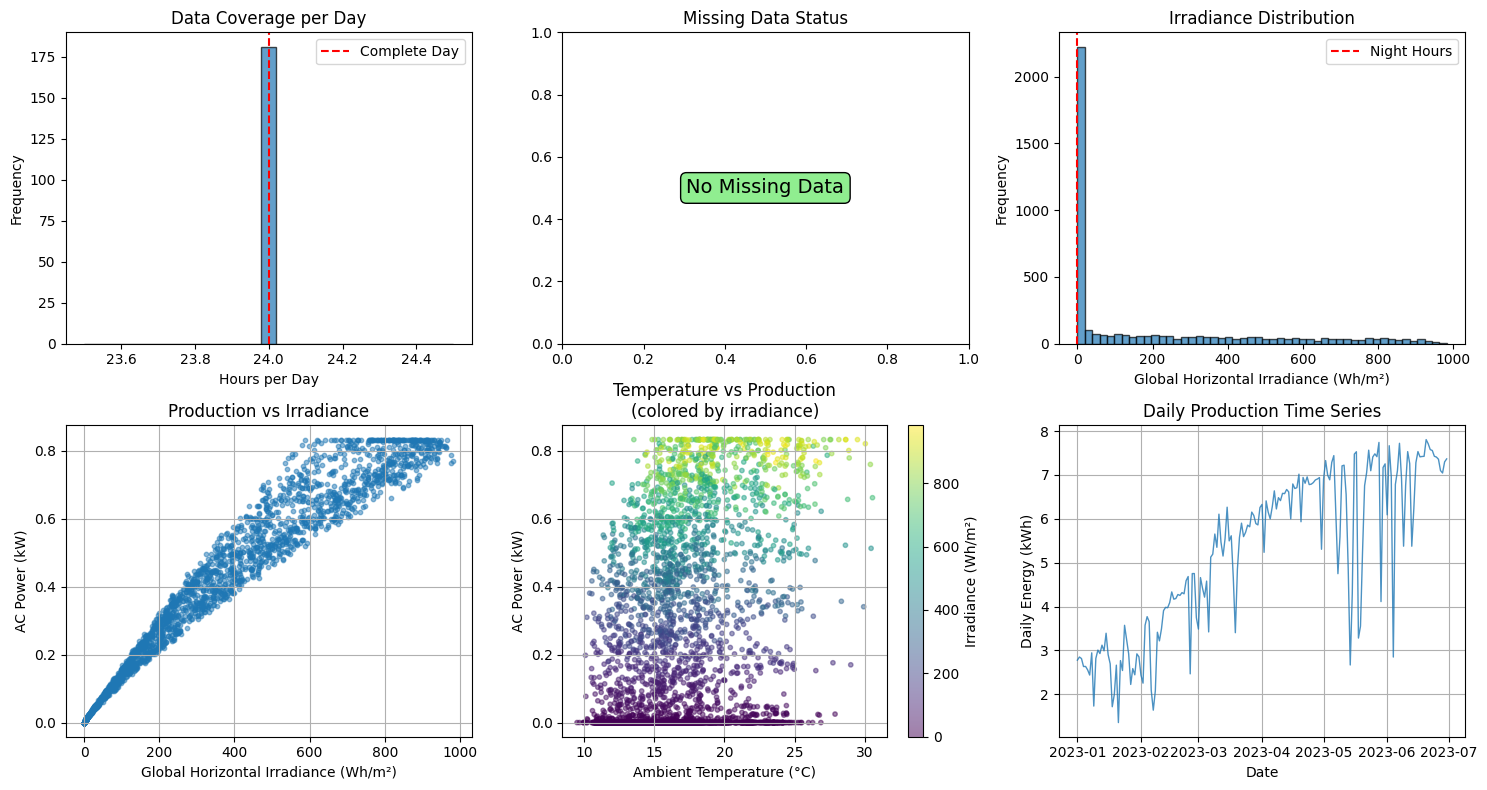

In [4]:
# Quick verification
print(df.columns.tolist())
assert 'pv_production_kwh' in df.columns, "pv_production_kwh missing"

# Safe alias for legacy callers
if 'pv_production_kwh' in df.columns and 'AC_POWER_KW' not in df.columns:
    df['AC_POWER_KW'] = df['pv_production_kwh']

# Now call diagnostics
plot_diagnostics(df)

üìà Creating comprehensive data overview...


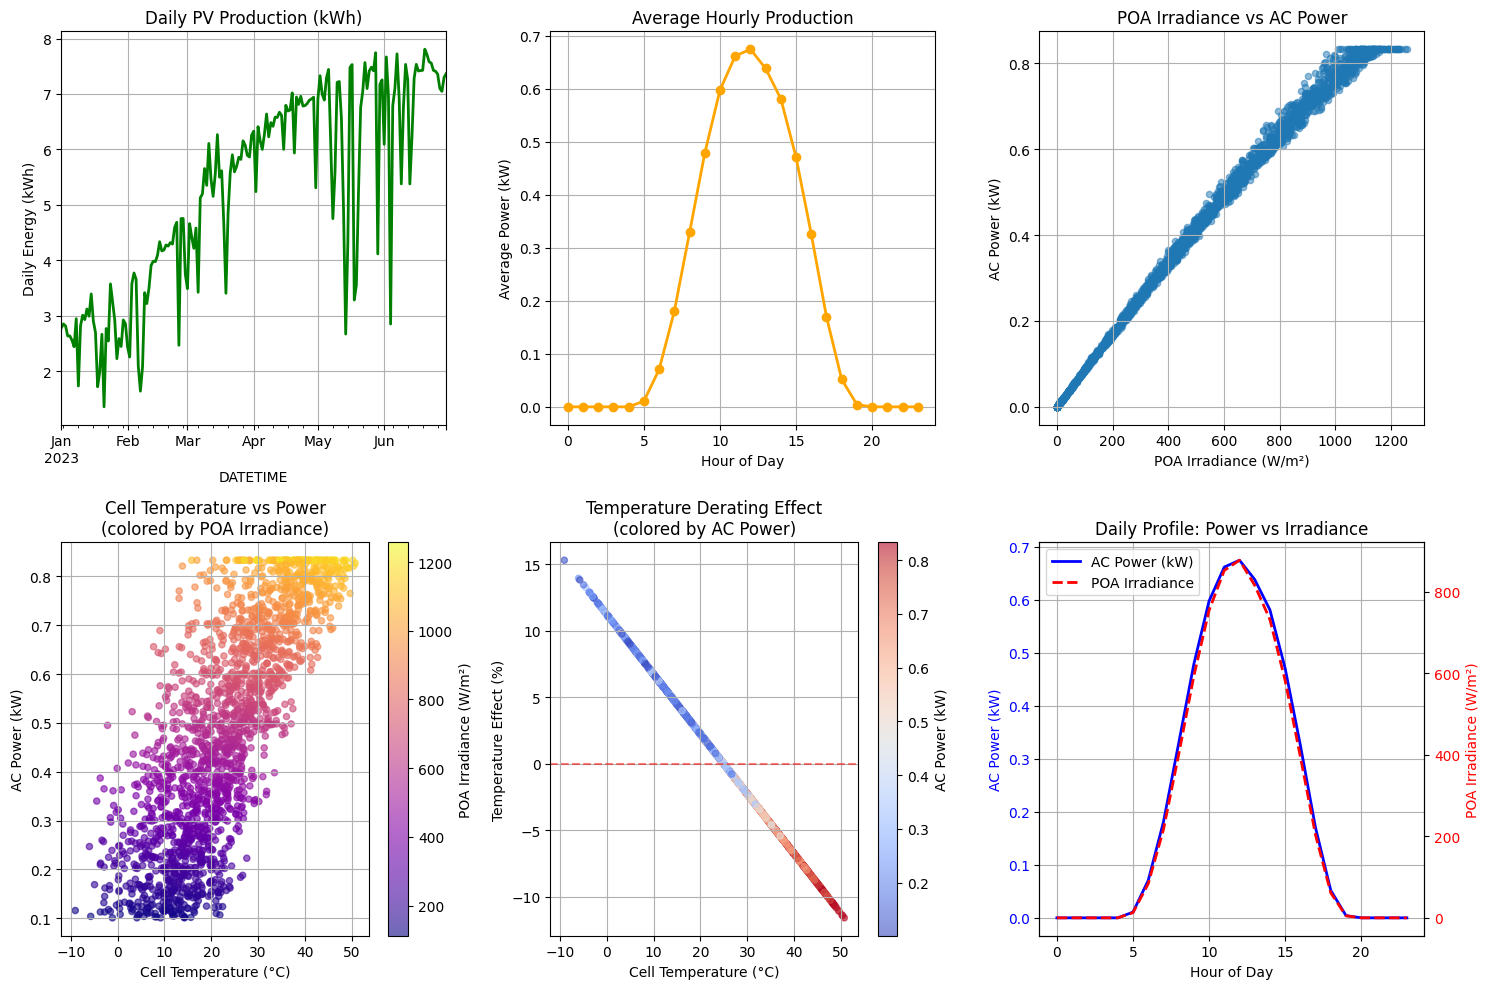

=== PRODUCTION SUMMARY ===
Total period: 2023-01-01 to 2023-06-30
Total energy produced: 949.4 kWh
Average daily production: 5.2 kWh/day
Peak daily production: 7.8 kWh
Capacity factor: 21.9%


In [5]:
# Comprehensive data overview
print("üìà Creating comprehensive data overview...")
plot_data_overview(df, system_params)

## 4. Machine Learning Experiments

In [6]:
# Prepare features for machine learning
print("üîß Preparing features for machine learning...")
df_ml = prepare_features_for_ml(df)
feature_columns = get_feature_columns()

print(f"ML dataset shape: {df_ml.shape}")
print(f"Number of features: {len(feature_columns)}")
print("\nFeature categories:")
print("  ‚Ä¢ Temporal: hour, month, day_of_week, is_weekend, hour_sin/cos, doy_sin/cos")
print("  ‚Ä¢ PV System: POA_IRRADIANCE, CELL_TEMP_C, TEMP_DERATE")
print("  ‚Ä¢ Weather: irradiance_wm2, clearness_ratio, T2M, WS10M, RH2M")
print("  ‚Ä¢ Lag Features: 1h, 2h, 3h, 24h lags for power, irradiance, temperature")
print("  ‚Ä¢ Rolling Features: 3h/6h rolling statistics")

üîß Preparing features for machine learning...
ML dataset shape: (4344, 49)
Number of features: 25

Feature categories:
  ‚Ä¢ Temporal: hour, month, day_of_week, is_weekend, hour_sin/cos, doy_sin/cos
  ‚Ä¢ PV System: POA_IRRADIANCE, CELL_TEMP_C, TEMP_DERATE
  ‚Ä¢ Weather: irradiance_wm2, clearness_ratio, T2M, WS10M, RH2M
  ‚Ä¢ Lag Features: 1h, 2h, 3h, 24h lags for power, irradiance, temperature
  ‚Ä¢ Rolling Features: 3h/6h rolling statistics


ü§ñ Running Machine Learning Experiments...
   This includes Random Forest and XGBoost with hyperparameter optimization
   Cross-validation, overfitting analysis, and feature importance
Final dataset size: 2294 samples
Number of features: 25
üéØ COMMON TRAIN/TEST SPLIT DEFINED:
   Training period: 2023-01-01 00:00:00 to 2023-05-24 23:00:00
   Test period: 2023-05-25 00:00:00 to 2023-06-30 23:00:00
   Train samples: 3,456
   Test samples: 888
   Test ratio: 20.4%
Training set: 1739 samples (75.8%)
Test set: 555 samples (24.2%)
Test period: 2023-05-25 05:00:00 to 2023-06-30 19:00:00
Training HIGHLY Regularized Random Forest with Cross-Validation...
Cross-Validation MAE: 0.0771 (+/- 0.0215)

Top 10 Most Important Features:
                       feature  importance
8               POA_IRRADIANCE    0.276252
19             ac_power_lag_24    0.215692
11              irradiance_wm2    0.138228
22    ac_power_rolling_3h_mean    0.101002
20        poa_irradiance_lag_1    0.079037
9         

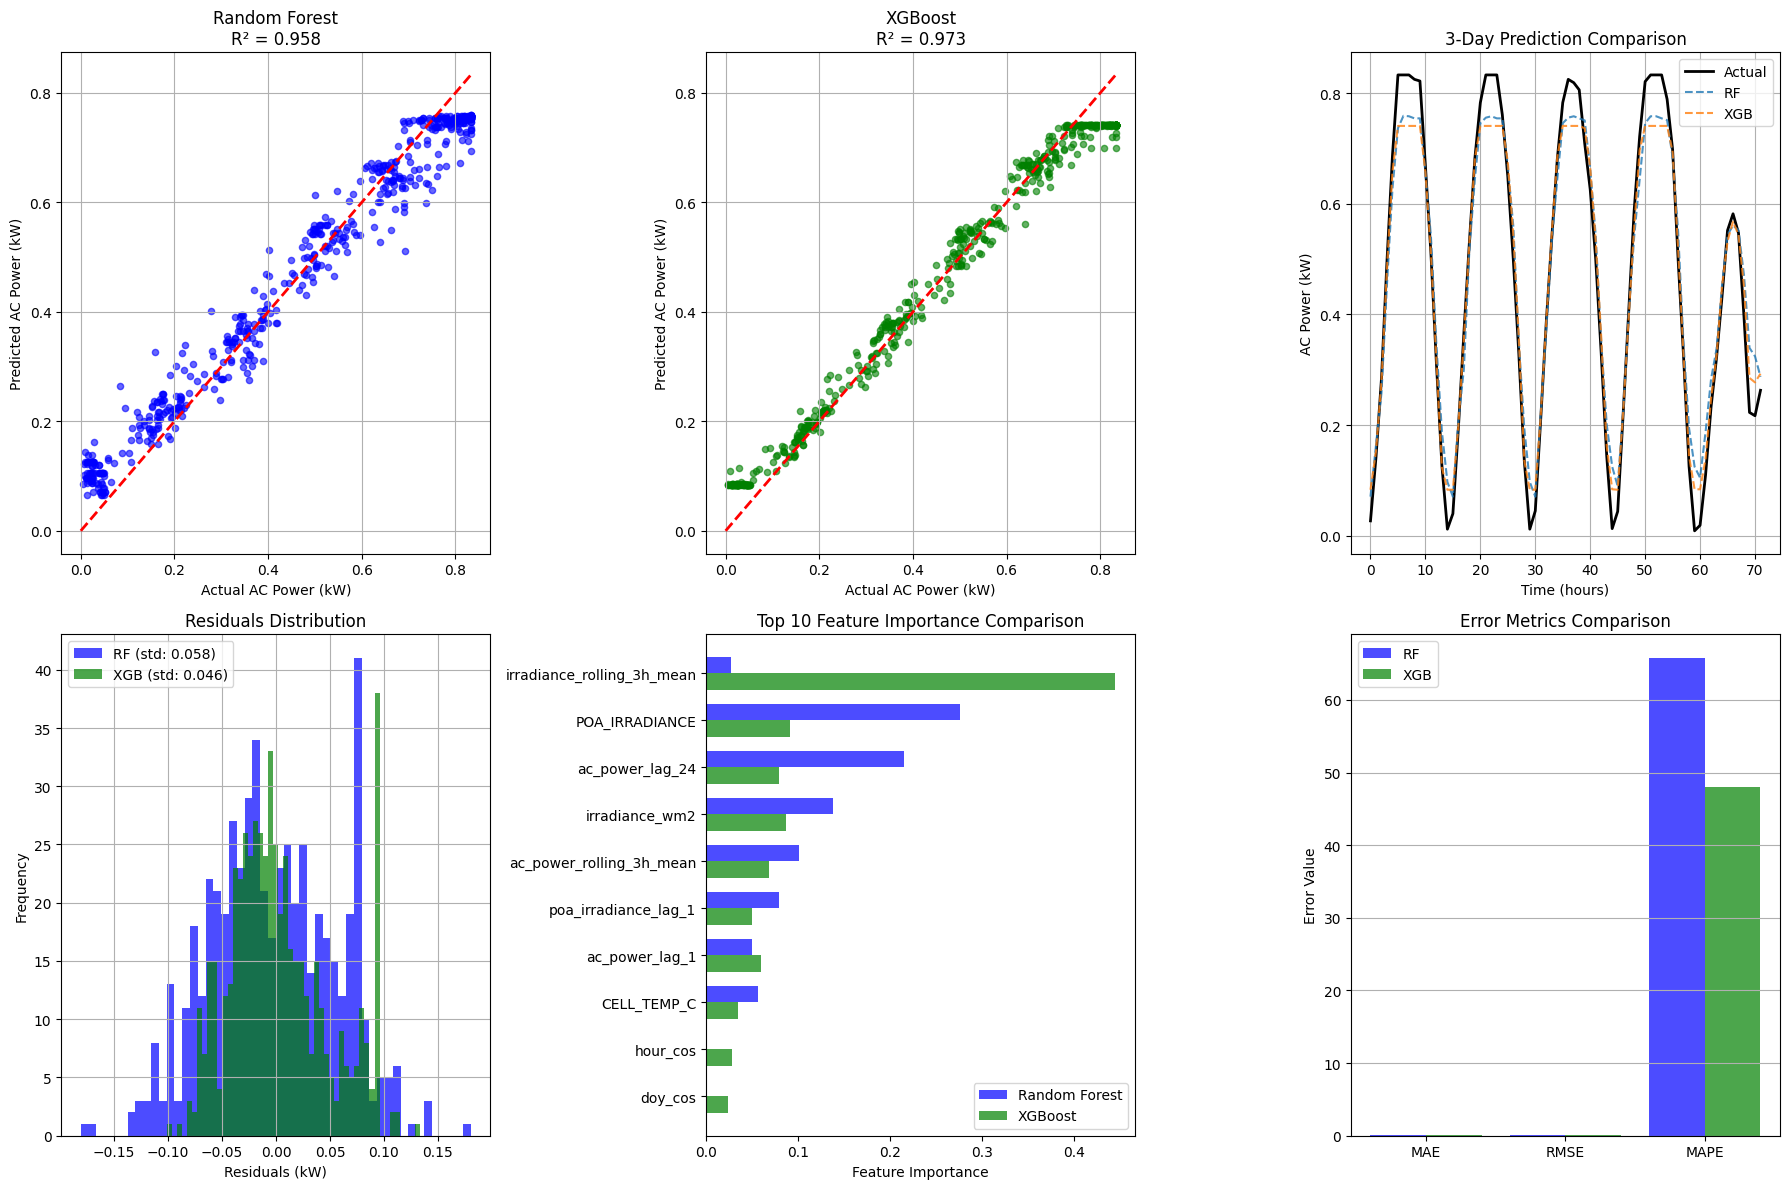


üé® Creating individual Random Forest prediction plots...


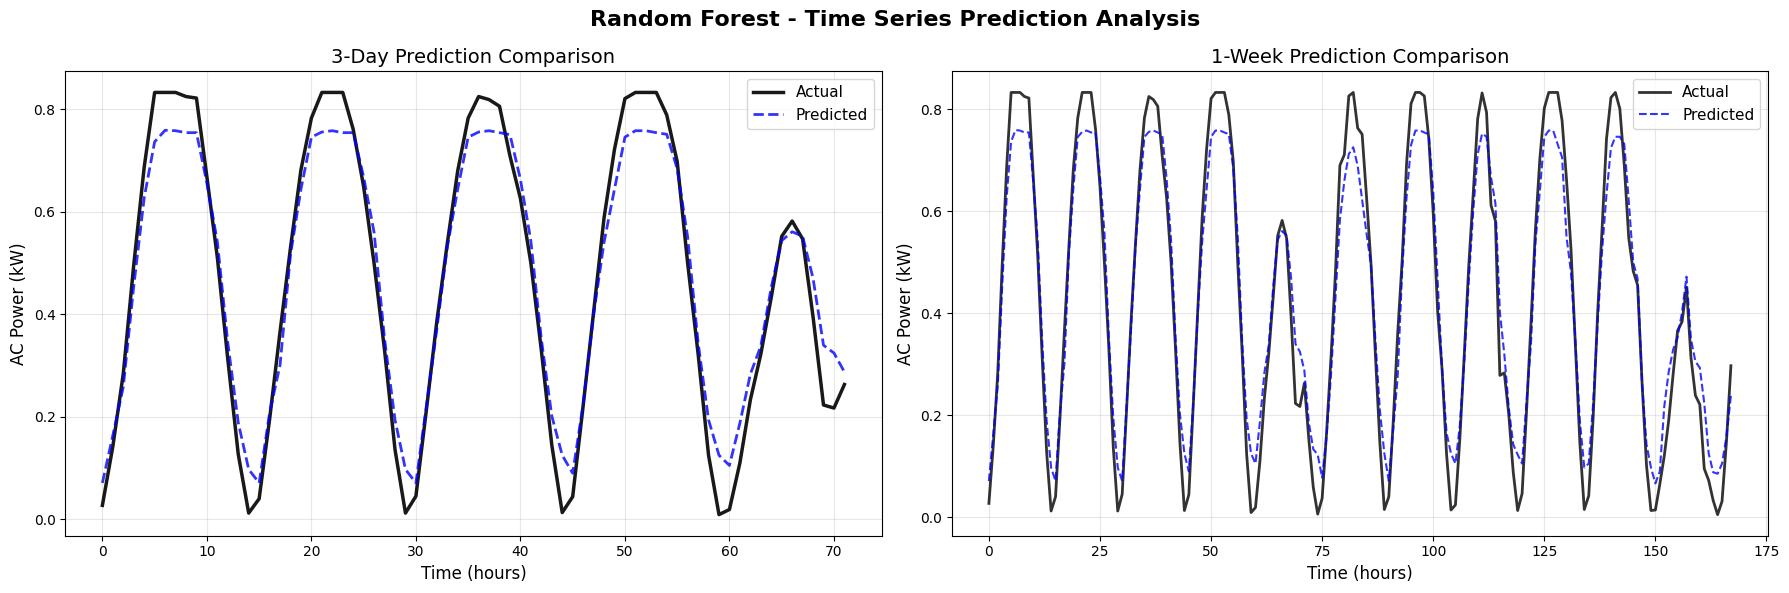

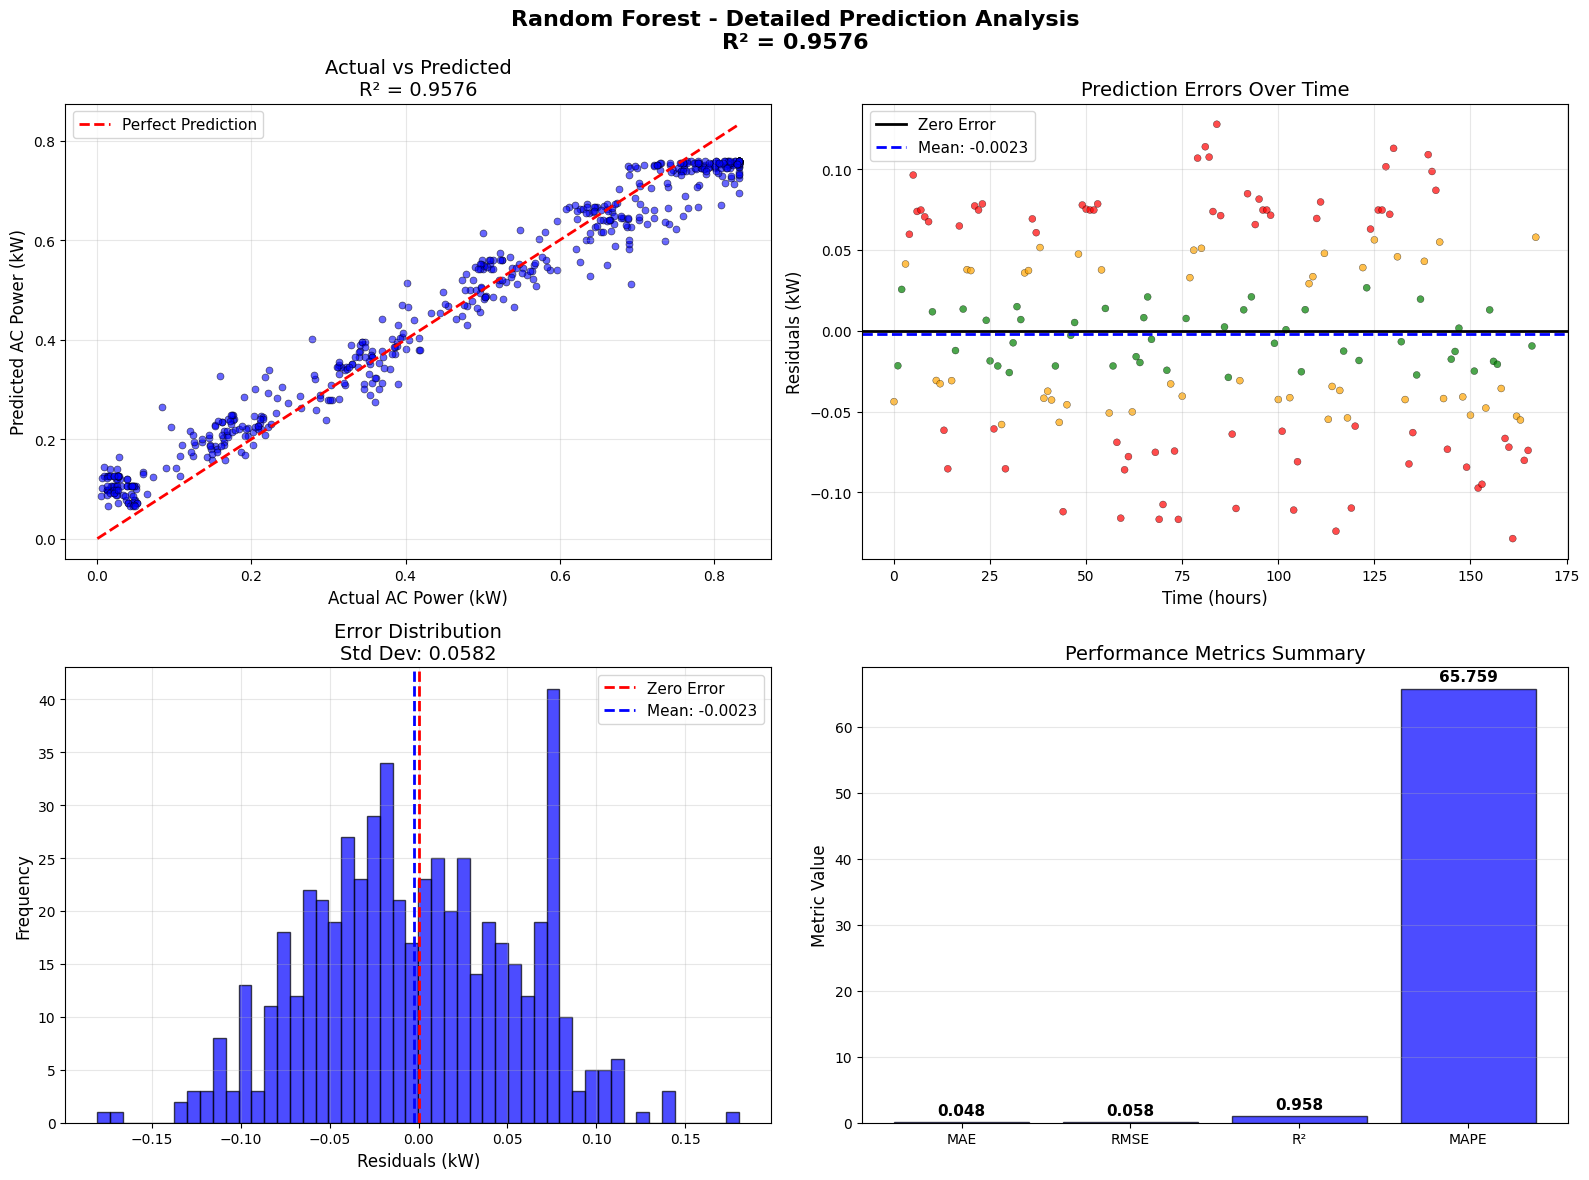


üìä Random Forest - Detailed Performance Metrics:
MAE:           0.048349 kW
RMSE:          0.058195 kW
R¬≤:            0.957637
Mean Residual: -0.002279 kW
Std Residual:  0.058203 kW
Max Error:     0.180694 kW

üé® Creating individual XGBoost prediction plots...


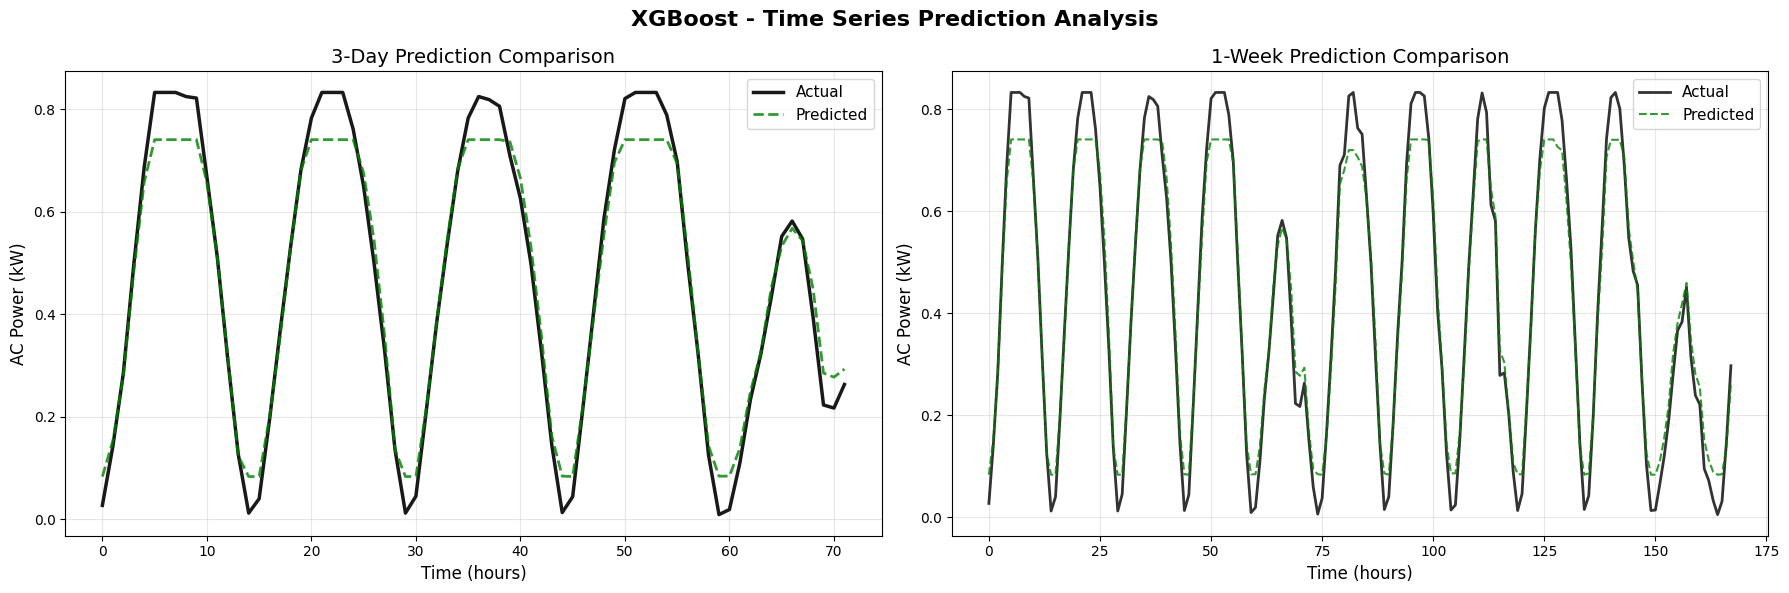

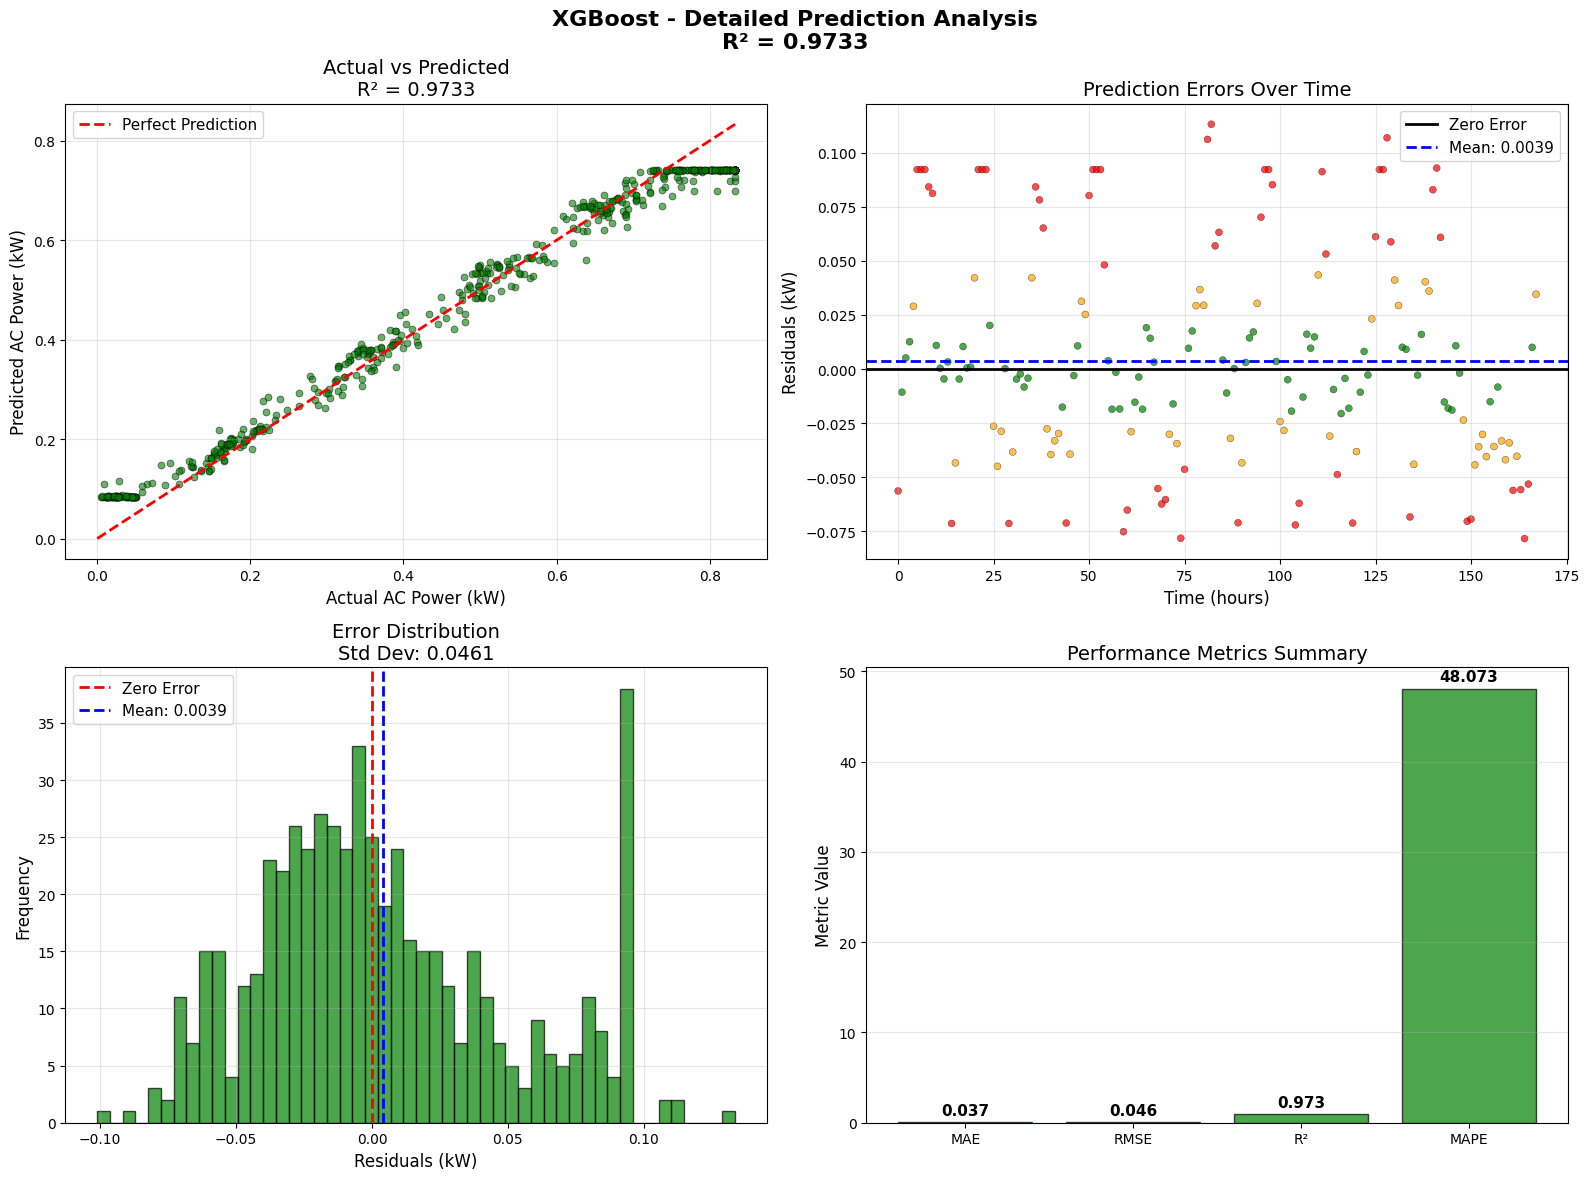


üìä XGBoost - Detailed Performance Metrics:
MAE:           0.036654 kW
RMSE:          0.046215 kW
R¬≤:            0.973284
Mean Residual: 0.003942 kW
Std Residual:  0.046088 kW
Max Error:     0.133508 kW

Predictions saved to 'data/solar_power_predictions_comparison.csv'

AGGREGATING ML PREDICTIONS TO DAILY kWh
Total valid samples for prediction: 2294
Generating Random Forest predictions...
Generating XGBoost predictions...

Hourly predictions shape: (2294, 3)
Date range: 2023-01-02 08:00:00 to 2023-06-30 19:00:00

Detected time interval: 0 days 01:00:00
Hours per reading: 1.000

Converting kW to kWh using factor: 1.0

Daily aggregated shape: (180, 3)
Days covered: 180

--- Sample Daily Predictions (first 5 days) ---
            Actual_kWh    RF_kWh   XGB_kWh
DATETIME                                  
2023-01-02       2.850  3.101952  3.047213
2023-01-03       2.815  3.052073  3.041013
2023-01-04       2.633  2.785254  2.756760
2023-01-05       2.635  2.880094  2.800474
2023-01-06   

In [7]:
# Run comprehensive ML experiments
print("ü§ñ Running Machine Learning Experiments...")
print("   This includes Random Forest and XGBoost with hyperparameter optimization")
print("   Cross-validation, overfitting analysis, and feature importance")

ml_results = run_ml_experiments(df, df_ml, feature_columns)

print("\n‚úÖ ML experiments completed successfully!")
print("   Models trained: Random Forest, XGBoost")
print("   Results saved to: solar_power_predictions_comparison.csv")

## 5. SARIMA Time Series Analysis

üìä Data already prepared with seasonal PV modeling...
   ‚úÖ Monthly tilt optimization already applied
üîç Running SARIMA Time Series Analysis...
   This includes:
   ‚Ä¢ Daily data aggregation for faster processing
   ‚Ä¢ Linear regression baseline with weather variables
   ‚Ä¢ Grid search for optimal SARIMA parameters
   ‚Ä¢ Cross-validation with time series splits
   ‚Ä¢ Residual modeling and forecasting
   ‚Ä¢ Comprehensive visualization and diagnostics
=== STARTING SARIMA EXPERIMENT ===
Converting hourly data to daily aggregation for SARIMA analysis...
Daily samples: 181 (reduced from 4344 hourly samples)
üéØ COMMON TRAIN/TEST SPLIT DEFINED:
   Training period: 2023-01-01 00:00:00 to 2023-05-24 00:00:00
   Test period: 2023-05-25 00:00:00 to 2023-06-30 00:00:00
   Train samples: 144
   Test samples: 37
   Test ratio: 20.4%
Baseline Linear Regression - MAE: 0.5731, RMSE: 0.6810
Adding simplified seasonal components (optimized for 6-month data)...
Simplified seasonal model R¬≤: 

Model search: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:12<00:00,  1.26it/s]



Completed: 16 valid models found

TOP 15 MODELS (sorted by adjusted CV-RMSE)
Rank  Order           Seasonal        CV-RMSE    Adjusted   Params 
--------------------------------------------------------------------------------
1     (0, 1, 0)       None            0.6090     0.6394     1      
2     (0, 0, 1)       None            0.6692     0.7027     1      
3     (0, 0, 2)       None            0.6458     0.7104     2      
4     (1, 1, 0)       None            0.6552     0.7207     2      
5     (1, 0, 0)       None            0.7165     0.7524     1      
6     (2, 1, 0)       None            0.6596     0.7585     3      
7     (1, 0, 1)       None            0.6922     0.7615     2      
8     (1, 0, 1)       (0, 0, 1, 7)    0.6025     0.7622     3      
9     (0, 1, 1)       None            0.6937     0.7631     2      
10    (1, 0, 2)       None            0.6996     0.8045     3      
11    (2, 0, 1)       None            0.7055     0.8113     3      
12    (2, 0, 0)       Non

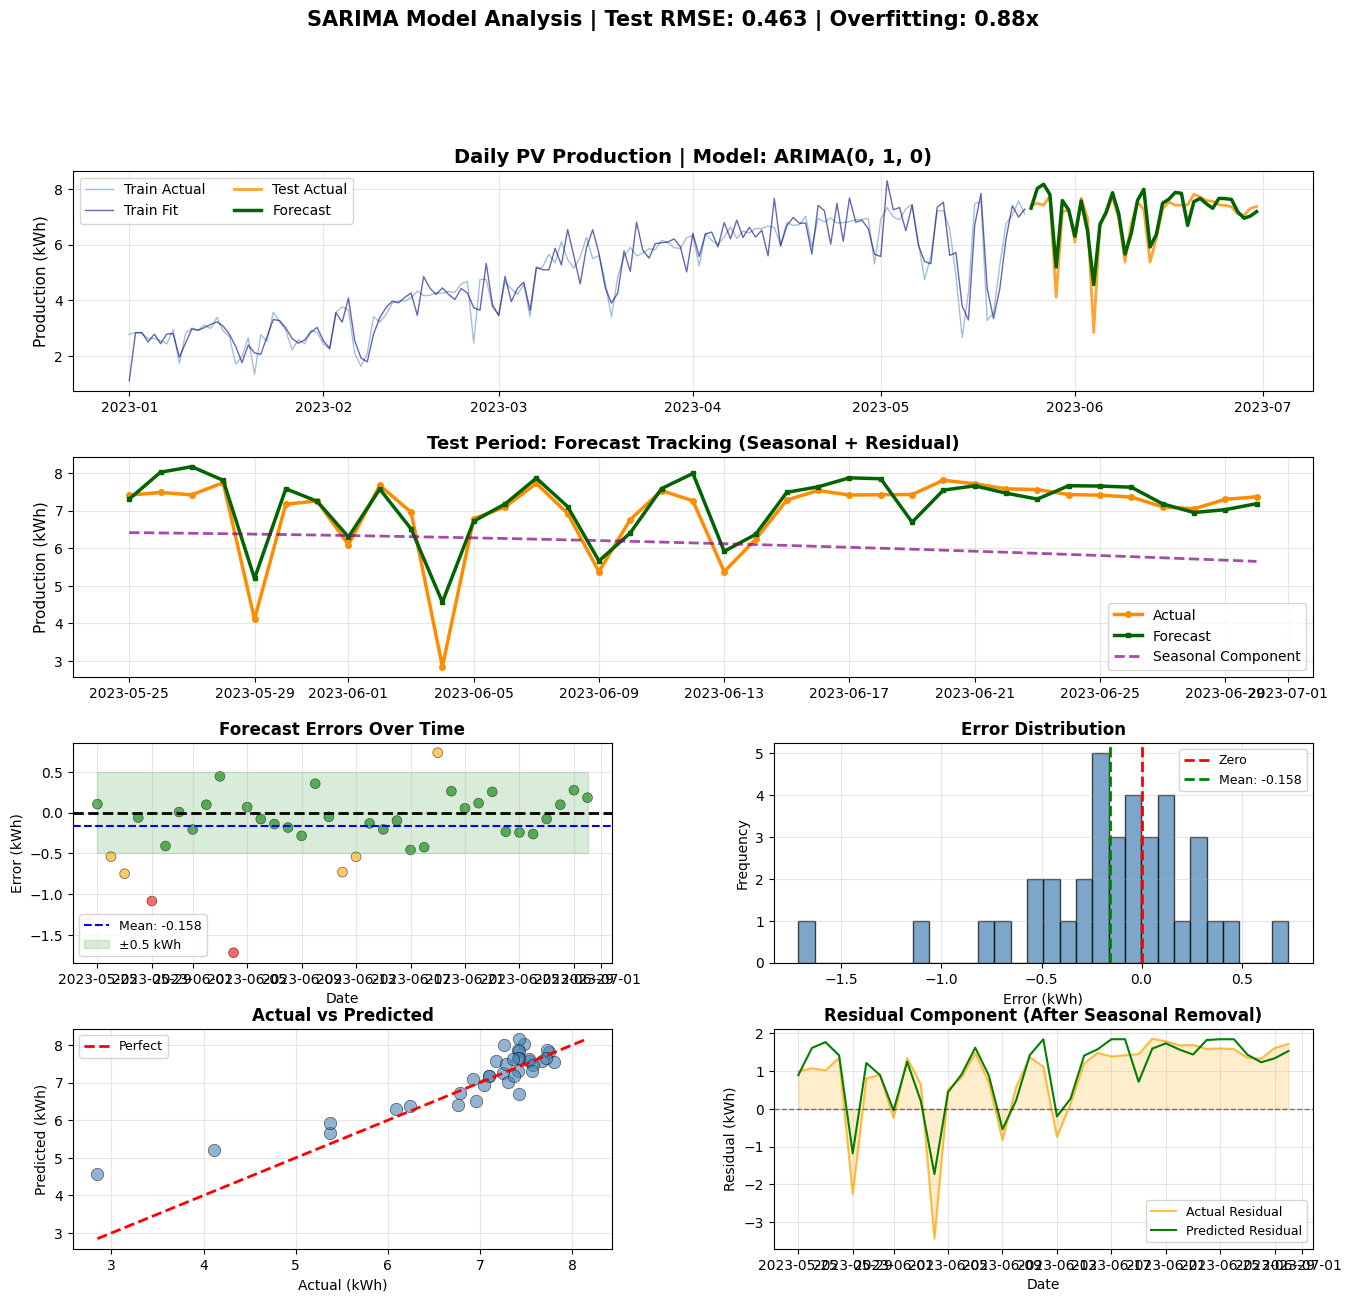

üìä Creating SARIMA diagnostic plots...


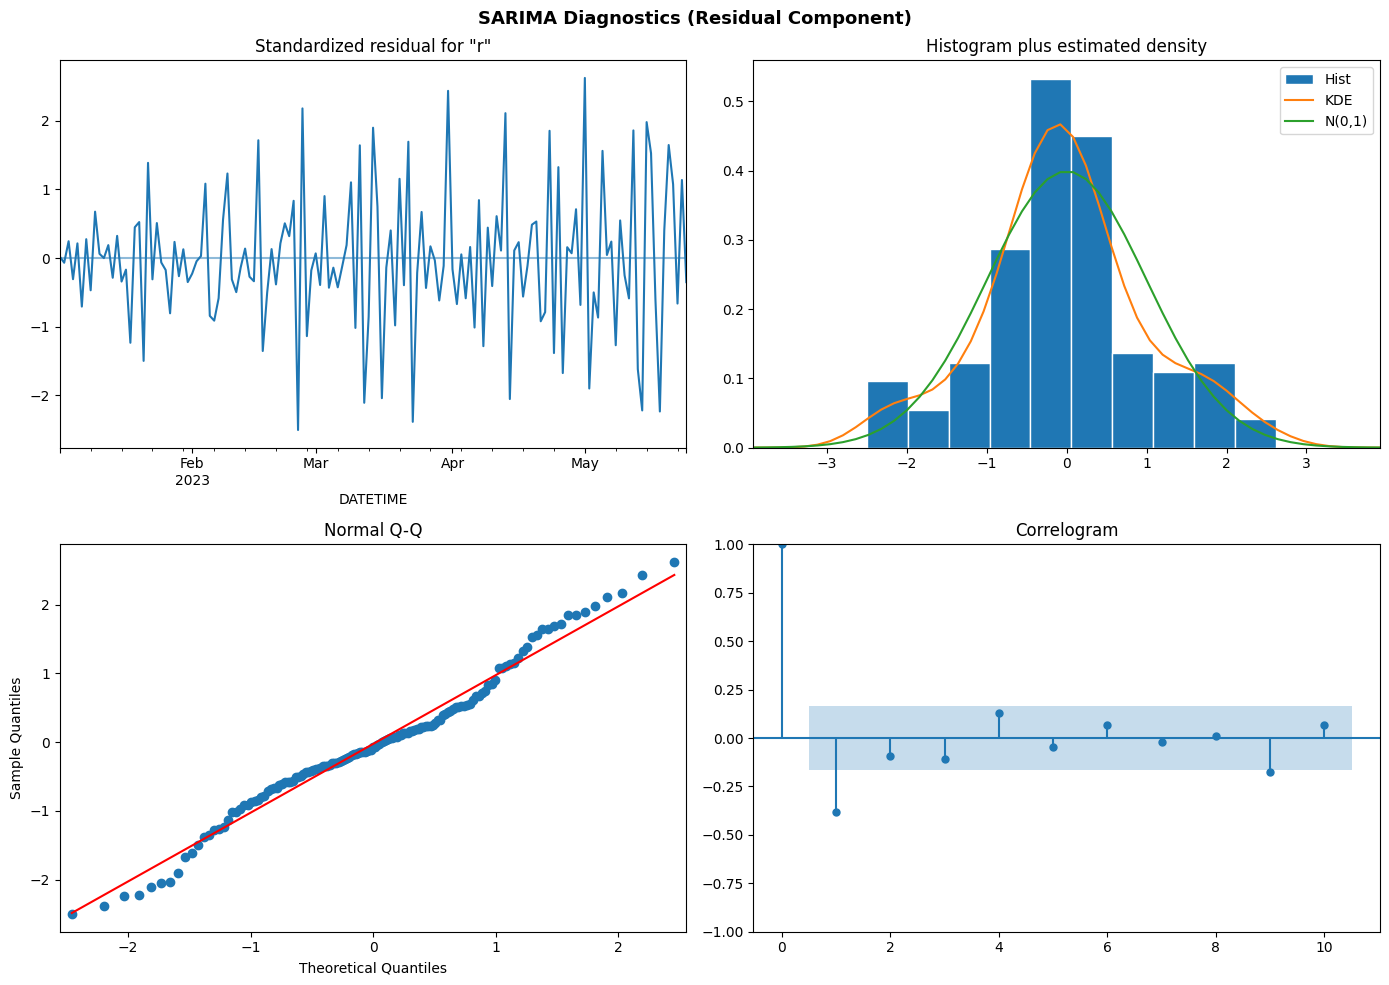


‚úÖ SARIMA analysis completed successfully!
   Best model: ARIMA(0, 1, 0)
   Final MAE: 0.3230
   Improvement over baseline: 74.7%

üìä SARIMA - Performance Summary:
MAE:               0.323040 kWh
RMSE:              0.463413 kWh
R¬≤:                0.7924932093457357
Overfitting RMSE:  0.88x
Overfitting MAE:   0.83x
Improvement:       74.7% over seasonal baseline
‚úÖ SARIMA shows good generalization (overfitting < 1.5x)
‚úÖ SARIMA shows significant improvement over seasonal baseline


In [8]:
# Data is already prepared with seasonal PV modeling from previous step
print("üìä Data already prepared with seasonal PV modeling...")
print("   ‚úÖ Monthly tilt optimization already applied")

print("üîç Running SARIMA Time Series Analysis...")
print("   This includes:")
print("   ‚Ä¢ Daily data aggregation for faster processing")
print("   ‚Ä¢ Linear regression baseline with weather variables")
print("   ‚Ä¢ Grid search for optimal SARIMA parameters")
print("   ‚Ä¢ Cross-validation with time series splits")
print("   ‚Ä¢ Residual modeling and forecasting")
print("   ‚Ä¢ Comprehensive visualization and diagnostics")

# Use the same data with seasonal modeling already applied
sarima_results = run_sarima_experiment(df)

print("\n‚úÖ SARIMA analysis completed successfully!")
print(f"   Best model: ARIMA{sarima_results['best_order']}")
if sarima_results['best_seasonal'] != (0, 0, 0, 0):
    print(f"   Seasonal: {sarima_results['best_seasonal']}")
print(f"   Final MAE: {sarima_results['sarima_metrics']['MAE']:.4f}")
print(f"   Improvement over baseline: {sarima_results['sarima_metrics']['MAE_Improvement_%']:.1f}%")

# Individual SARIMA performance analysis
plot_individual_sarima_predictions(sarima_results)

## 5.5. LSTM Deep Learning Analysis

üß† Running LSTM Deep Learning Analysis...
   This includes:
   ‚Ä¢ Sequential data preparation with time steps
   ‚Ä¢ Multi-layer LSTM architecture (128‚Üí64‚Üí32 neurons)
   ‚Ä¢ Dropout regularization to prevent overfitting
   ‚Ä¢ Early stopping with validation monitoring
   ‚Ä¢ Comprehensive evaluation and visualization
   ‚Ä¢ Overfitting analysis and generalization metrics
üî¨ Running LSTM Deep Learning Experiment
üîß Preparing LSTM data with 24 time steps...
   Using 10 features: ['ALLSKY_SFC_SW_DWN', 'POA_IRRADIANCE', 'T2M', 'CELL_TEMP_C', 'TEMP_DERATE', 'WS10M', 'RH2M', 'hour', 'month', 'clearness_ratio']
   Sequences created: X shape (4320, 24, 10), y shape (4320, 1)
üéØ COMMON TRAIN/TEST SPLIT DEFINED:
   Training period: 2023-01-01 00:00:00 to 2023-05-24 23:00:00
   Test period: 2023-05-25 00:00:00 to 2023-06-30 23:00:00
   Train samples: 3,456
   Test samples: 888
   Test ratio: 20.4%
üìä LSTM Data Split (Common Test Period):
   Train: 2,918 sequences
   Validation: 514

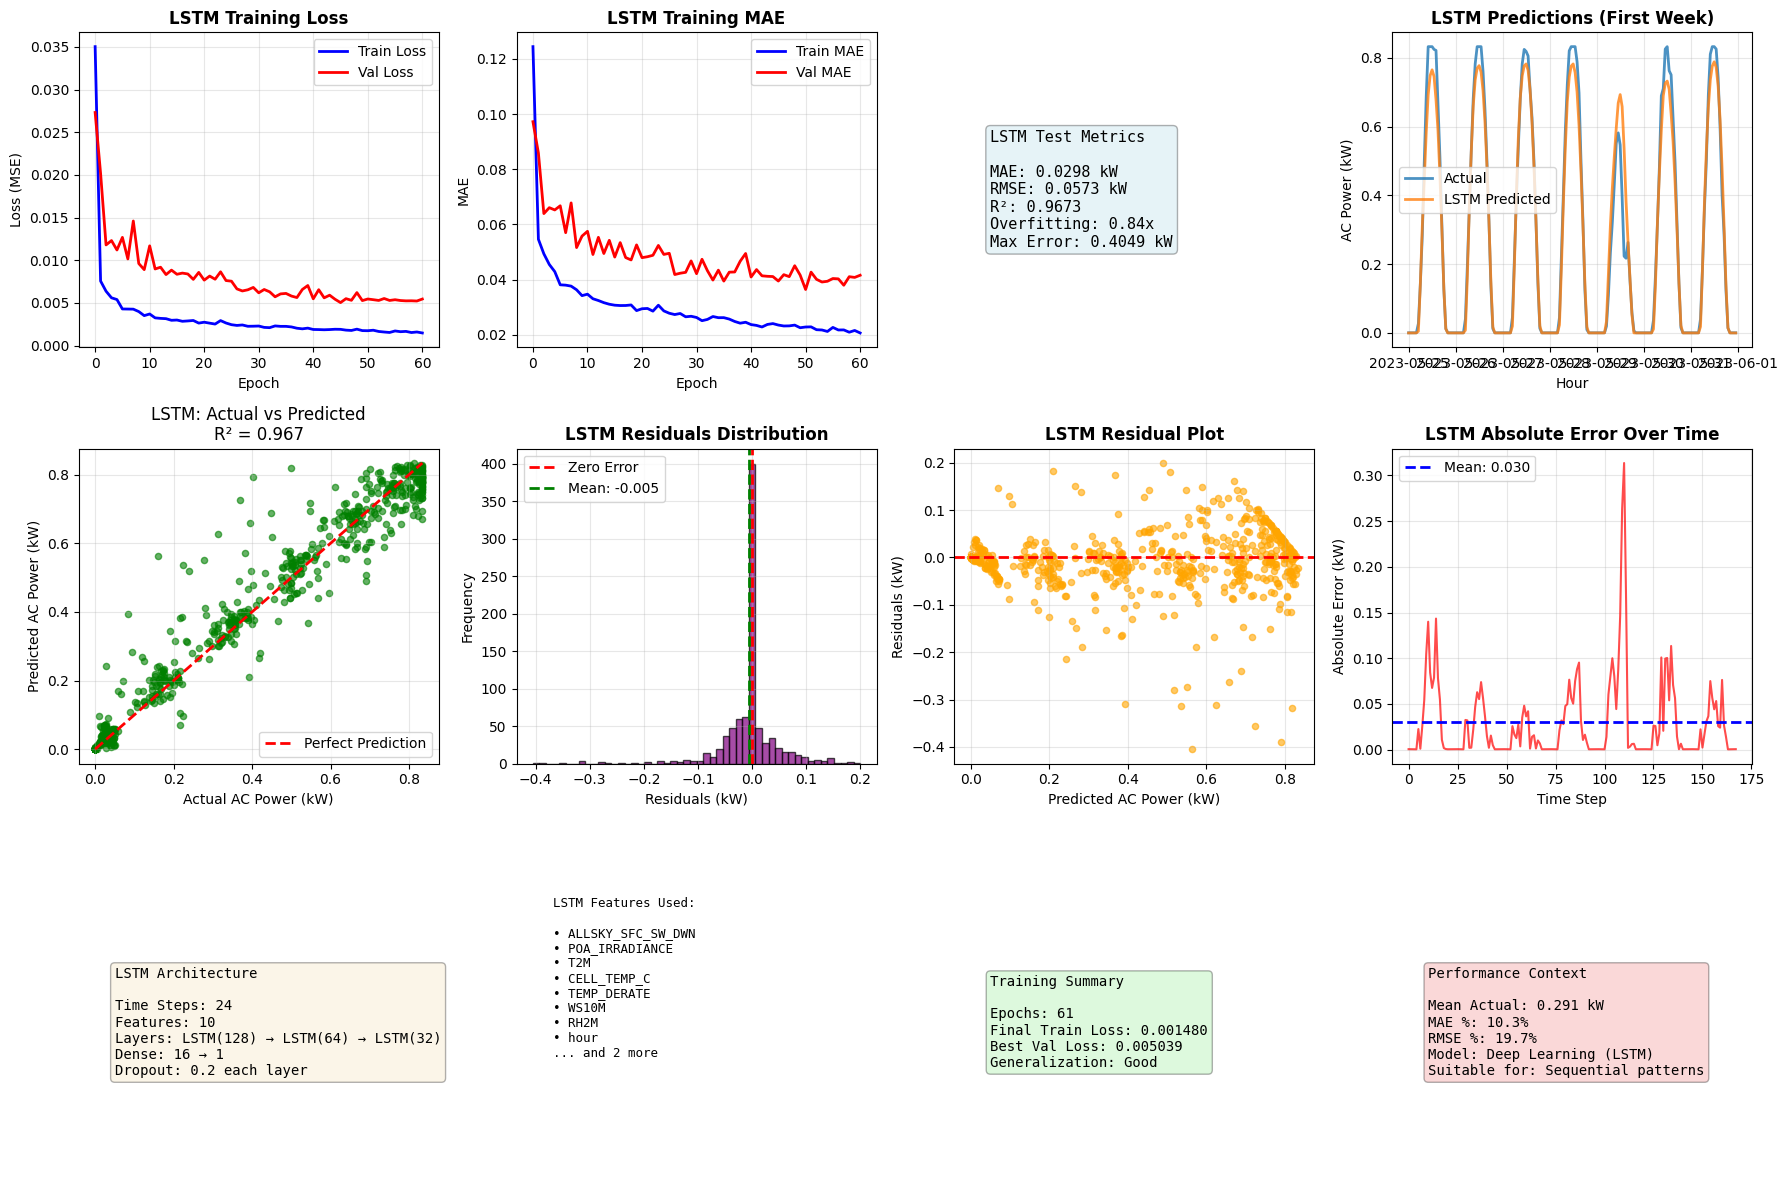

‚úÖ LSTM visualization completed!

‚úÖ LSTM experiment completed successfully!

‚úÖ LSTM analysis completed successfully!
   Architecture: Multi-layer LSTM with 24-hour lookback
   Final MAE: 0.0298
   Final R¬≤: 0.9673
   Epochs trained: 61
   Overfitting: 0.84x

LSTM DEEP LEARNING - PERFORMANCE SUMMARY
MAE:              0.029785 kW
RMSE:             0.057340 kW
R¬≤:               0.967318
Overfitting MAE:  0.84x
Overfitting RMSE: 0.80x
‚úÖ LSTM shows good generalization (overfitting < 1.5x)
‚úÖ LSTM shows excellent predictive performance (R¬≤ > 0.9)


In [9]:
# Run LSTM Deep Learning Experiment
print("üß† Running LSTM Deep Learning Analysis...")
print("   This includes:")
print("   ‚Ä¢ Sequential data preparation with time steps")
print("   ‚Ä¢ Multi-layer LSTM architecture (128‚Üí64‚Üí32 neurons)")
print("   ‚Ä¢ Dropout regularization to prevent overfitting")
print("   ‚Ä¢ Early stopping with validation monitoring")
print("   ‚Ä¢ Comprehensive evaluation and visualization")
print("   ‚Ä¢ Overfitting analysis and generalization metrics")

# Use the same data with seasonal modeling already applied
lstm_results = run_lstm_experiment(df, time_steps=24, epochs=100, batch_size=32)

print("\n‚úÖ LSTM analysis completed successfully!")
if 'error' not in lstm_results:
    print("   Architecture: Multi-layer LSTM with 24-hour lookback")
    print(f"   Final MAE: {lstm_results['lstm_metrics']['MAE']:.4f}")
    print(f"   Final R¬≤: {lstm_results['lstm_metrics']['R¬≤']:.4f}")
    print(f"   Epochs trained: {lstm_results['model_summary']['epochs_trained']}")
    print(f"   Overfitting: {lstm_results['lstm_metrics'].get('Overfitting_MAE', 'N/A'):.2f}x")
else:
    print(f"   ‚ö†Ô∏è LSTM Error: {lstm_results['error']}")

# Individual LSTM performance analysis
print_lstm_performance_summary(lstm_results)

## 6. Comprehensive Results Comparison

üìä Creating comprehensive results comparison...


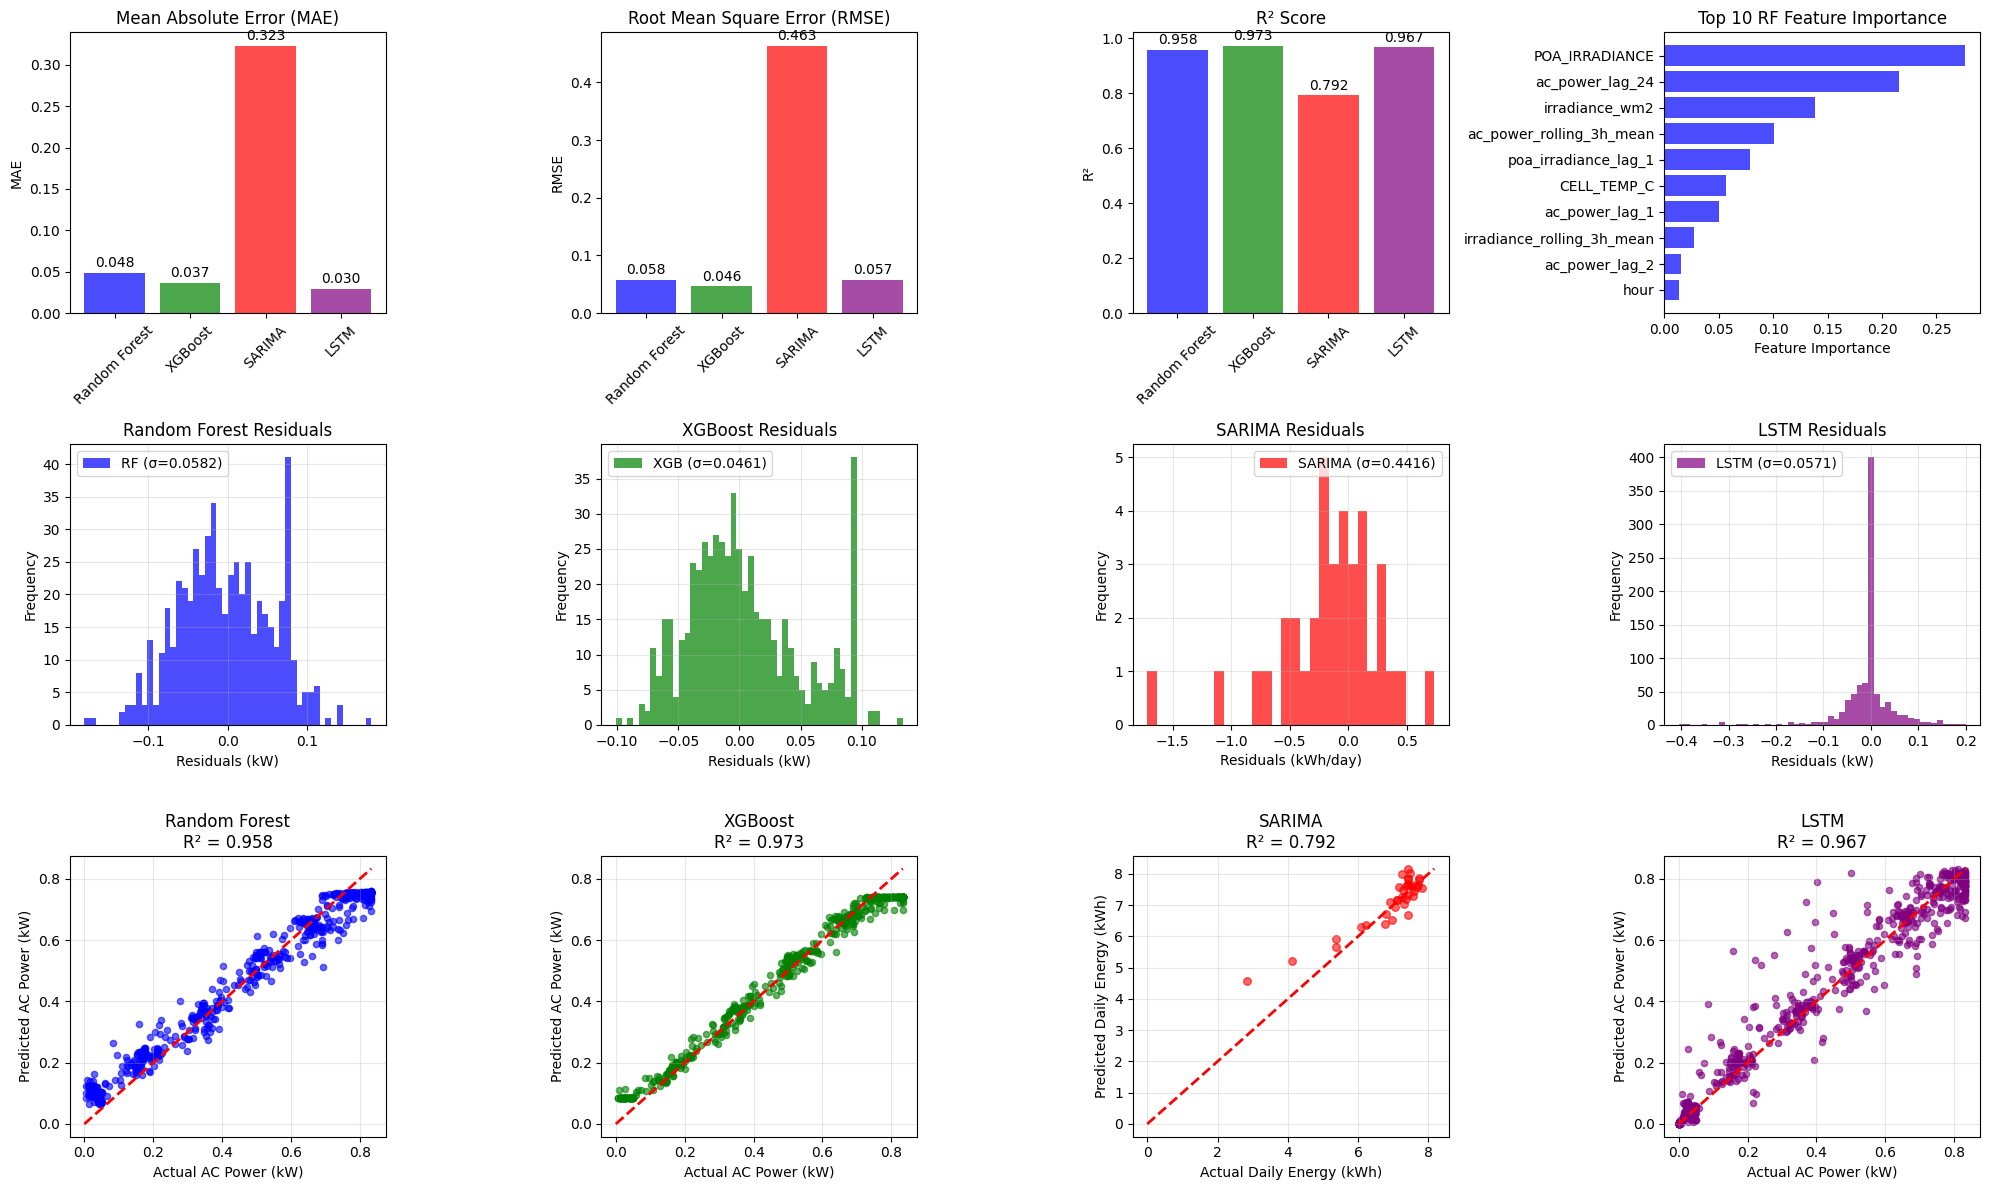


üìä Creating DAILY Aggregated Comparison (All Models)
‚úÖ SARIMA (Daily): 37 days
   Index range: 2023-05-25 00:00:00 to 2023-06-30 00:00:00
‚úÖ ML Models (Aggregated to Daily): 180 days
   Index range: 2023-01-02 00:00:00 to 2023-06-30 00:00:00
‚úÖ ML Models (Aggregated to Daily): 180 days
   Index range: 2023-01-02 00:00:00 to 2023-06-30 00:00:00
‚úÖ LSTM (Aggregated to Daily): 37 days
   Index range: 2023-05-25 00:00:00 to 2023-06-30 00:00:00

‚úÖ Common date range: 37 days
   From 2023-05-25 00:00:00 to 2023-06-30 00:00:00


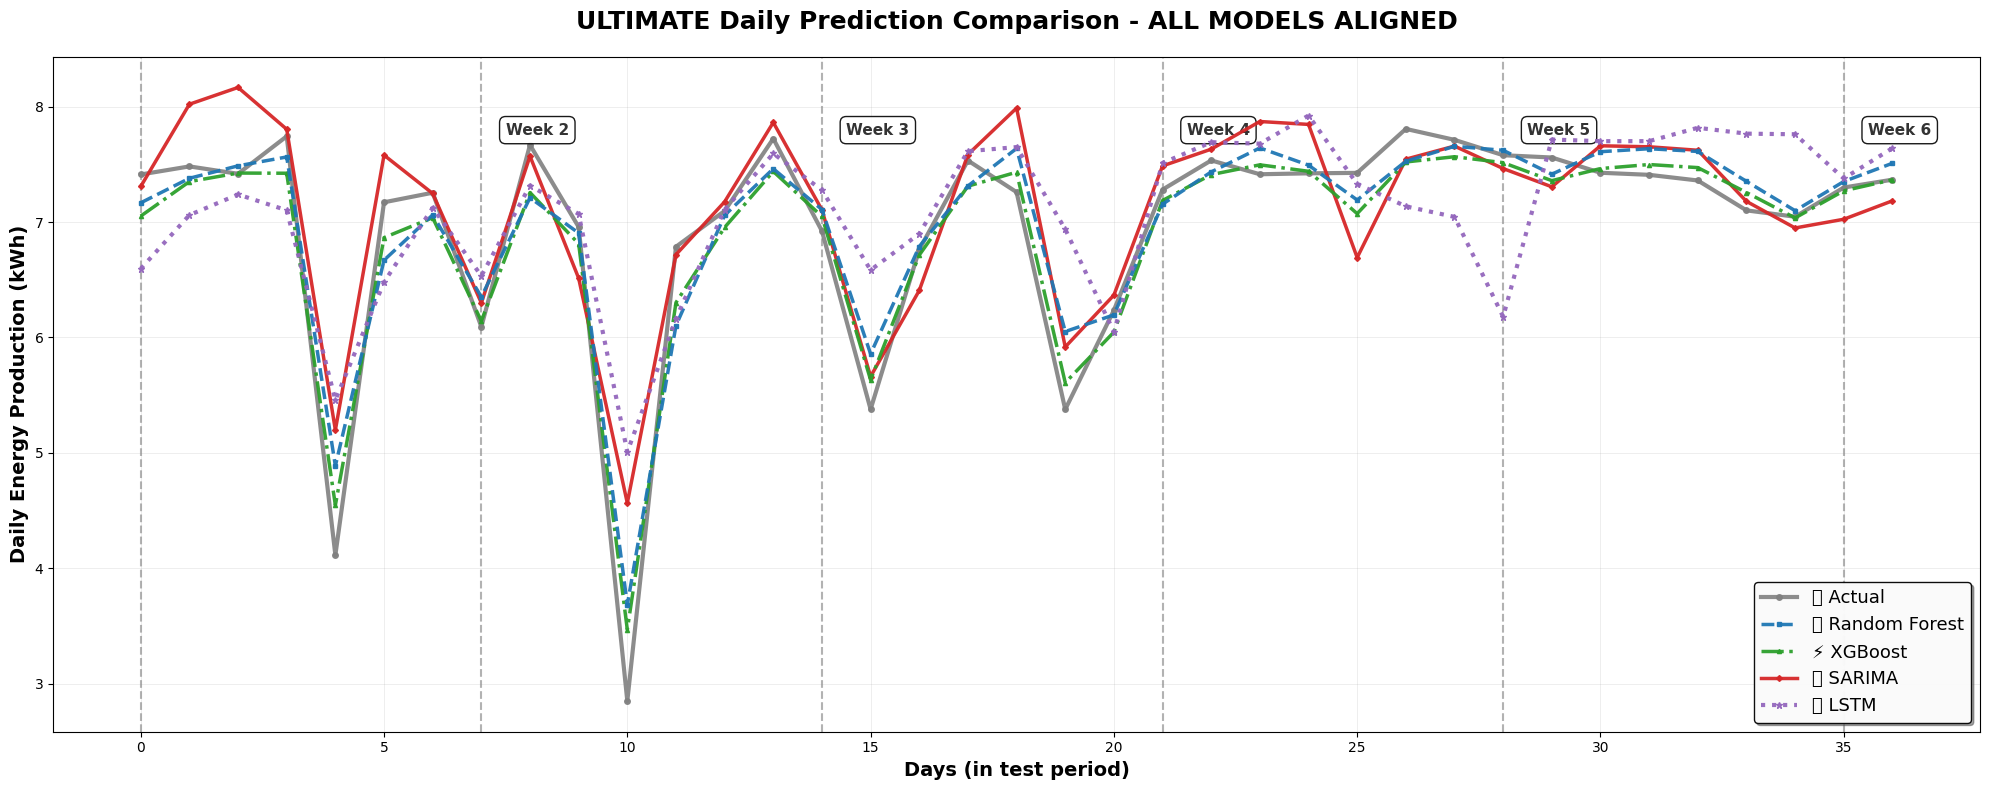


COMPREHENSIVE MODEL COMPARISON
        Model    MAE   RMSE     R¬≤
Random Forest 0.0483 0.0582 0.9576
      XGBoost 0.0367 0.0462 0.9733
       SARIMA 0.3230 0.4634 0.7925
         LSTM 0.0298 0.0573 0.9673


In [10]:
# Combine all results for comparison
all_results = {
    'ml_results': ml_results,
    'sarima_results': sarima_results,
    'lstm_results': lstm_results,
}

print("üìä Creating comprehensive results comparison...")
comparison_df, daily_metrics = plot_model_results_comparison(all_results)

In [11]:
# Print comprehensive performance summary
print_performance_summar
y(df, system_params, all_results)

NameError: name 'print_performance_summar' is not defined

## 7. Save Results and Final Analysis

In [12]:
# Save comprehensive results
print("üíæ Saving final results...")

# Save processed data with all calculated features
save_results(df, 'results/processed_solar_data_complete.csv')
print("   ‚úÖ Complete processed data saved to: results/processed_solar_data_complete.csv")

# Save model comparison summary
comparison_df.to_csv('results/model_comparison_summary.csv', index=False)
print("   ‚úÖ Model comparison saved to: results/model_comparison_summary.csv")

# Create final summary report
summary_report = {
    'analysis_period': f"{df.index.min()} to {df.index.max()}",
    'total_hours': len(df),
    'system_capacity_kw': system_params['capacity_kw'],
    'total_production_kwh': metrics['total_production_kwh'],
    'capacity_factor_percent': metrics['capacity_factor_percent'],
    'best_model_mae': comparison_df['MAE'].min(),
    'best_model_name': comparison_df.loc[comparison_df['MAE'].idxmin(), 'Model'],
    'random_forest_r2': ml_results['rf_metrics']['R¬≤'],
    'xgboost_r2': ml_results['xgb_metrics']['R¬≤'],
    'sarima_mae_improvement_percent': sarima_results['sarima_metrics']['MAE_Improvement_%'],
    'lstm_available': 'error' not in lstm_results,
    'lstm_r2': lstm_results['lstm_metrics']['R¬≤'] if 'error' not in lstm_results else 'N/A'
}

# Save as JSON for easy reading
import json
with open('results/analysis_summary.json', 'w') as f:
    json.dump(summary_report, f, indent=2, default=str)

print("   ‚úÖ Analysis summary saved to: results/analysis_summary.json")

print("\nüéâ ANALYSIS COMPLETE! üéâ")
print("\nüìã Summary of Results:")
print(f"   ‚Ä¢ Data Period: {summary_report['analysis_period']}")
print(f"   ‚Ä¢ Total Production: {summary_report['total_production_kwh']:.1f} kWh")
print(f"   ‚Ä¢ Capacity Factor: {summary_report['capacity_factor_percent']:.1f}%")
print(f"   ‚Ä¢ Best Model: {summary_report['best_model_name']} (MAE: {summary_report['best_model_mae']:.4f})")
print(f"   ‚Ä¢ Random Forest R¬≤: {summary_report['random_forest_r2']:.4f}")
print(f"   ‚Ä¢ XGBoost R¬≤: {summary_report['xgboost_r2']:.4f}")
print(f"   ‚Ä¢ SARIMA Improvement: {summary_report['sarima_mae_improvement_percent']:.1f}%")
if summary_report['lstm_available']:
    print(f"   ‚Ä¢ LSTM R¬≤: {summary_report['lstm_r2']:.4f}")
else:
    print("   ‚Ä¢ LSTM: Not available (requires TensorFlow)")

print("\nüìÅ All results saved in the 'results/' directory")
print("üìä Analysis complete - check the visualizations above for detailed insights!")
print("\nü§ñ Models compared:")
print("   ‚Ä¢ Random Forest (Ensemble ML)")
print("   ‚Ä¢ XGBoost (Gradient Boosting)")  
print("   ‚Ä¢ SARIMA (Statistical Time Series)")
print("   ‚Ä¢ LSTM (Deep Learning - Sequential)")

üíæ Saving final results...
Results saved to results/processed_solar_data_complete.csv
   ‚úÖ Complete processed data saved to: results/processed_solar_data_complete.csv
   ‚úÖ Model comparison saved to: results/model_comparison_summary.csv
   ‚úÖ Analysis summary saved to: results/analysis_summary.json

üéâ ANALYSIS COMPLETE! üéâ

üìã Summary of Results:
   ‚Ä¢ Data Period: 2023-01-01 00:00:00 to 2023-06-30 23:00:00
   ‚Ä¢ Total Production: 949.4 kWh
   ‚Ä¢ Capacity Factor: 26.2%
   ‚Ä¢ Best Model: LSTM (MAE: 0.0363)
   ‚Ä¢ Random Forest R¬≤: 0.9576
   ‚Ä¢ XGBoost R¬≤: 0.9733
   ‚Ä¢ SARIMA Improvement: 74.7%
   ‚Ä¢ LSTM R¬≤: 0.9552

üìÅ All results saved in the 'results/' directory
üìä Analysis complete - check the visualizations above for detailed insights!

ü§ñ Models compared:
   ‚Ä¢ Random Forest (Ensemble ML)
   ‚Ä¢ XGBoost (Gradient Boosting)
   ‚Ä¢ SARIMA (Statistical Time Series)
   ‚Ä¢ LSTM (Deep Learning - Sequential)
